# Introduction

# Imports

In [64]:
import glob # To read all files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import spacy
import mlflow
import mlflow.sklearn


from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.fr import French

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
import warnings
from joblib import load, dump

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
warnings.filterwarnings('ignore')

In [65]:
nlp = French()
stemmer = SnowballStemmer("french")

In [35]:
PUNCTUATIONS = string.punctuation

# Read Dataset

In [36]:
files = glob.glob('../dataset/documents/*.json')

file_list = []
content_list = []

for file in files:
    with open(file, 'r') as f:
        j_obj = json.load(f)
        
        file_list.append(j_obj['filename'])
        content_list.append(j_obj['clauses'])
    
df = pd.DataFrame(zip(file_list, content_list) ,columns= ['filename', 'clauses'])

In [37]:
df.head()

,filename,clauses
0,161102 statuts à jour -OCR_OCR-pdfa,[PDM NETWORKS SOCIETE A RESPONSABILITE LIMITEE...
1,17. Statuts post RK-OCR_OCR-pdfa,[INIFLUX Société par actions simplifiée au cap...
2,2016 06 12 Statuts-OCR_OCR-pdfa,[ICI Société par actions simplifiée au capital...
3,2016 09 29 Statuts modifiés AssurCopro - copie...,[ASSURCOPRO Société par Actions Simplifiée au ...
4,2016 09 29 Statuts modifiés AssurCopro Sud-OCR...,[AssurCopro Sud Société par actions simplifiée...


# Process data

In [58]:
df['clauses'][0]

['PDM NETWORKS SOCIETE A RESPONSABILITE LIMITEE Au capital de 191 100 Siège social 7, Allée de la Doucerie 78 620 L Etang la Ville S TATUT S T. PDM NETWORKS Shown',
 'ARTICLE ler FORME La société est une société à responsabilité limitée. Elle est régie par les présents statuts établis sous seing privé à Boulogne Billancourt ce jour. Elle a un caractère unipersonnel qu elle peut perdre sans modification de forme.',
 'ARTICLE 2 DENOMINATION La société est dénommée : PDM NETWORKS',
 'ARTICLE 3 OBJET La société a pour objet : Le conseil pour les affaires et autres conseils de gestion ; L acquisition, la détention, la gestion de participations au capital de toutes sociétés ; L animation de ses filiales et la réalisation de prestations de services à destination de celles ci ; Elle peut réaliser toutes les opérations qui sont compatibles avec cet objet, s y rapportent et contribuent à sa réalisation.',
 'ARTICLE 4 SIEGE Le siège de la société est fixé à : 7, Allée de la Doucerie 78 620 L Etan

In [54]:
def process_clauses(text):
    """
        Function to process the clauses and return a clean text
    """

    processed_text = ''.join(str(val).lower() for val in text)
    
    return processed_text  

In [55]:
df['processed_clause'] = df['clauses'].apply(lambda text: process_clauses(text))
df.head()

,filename,clauses,processed_clause
0,161102 statuts à jour -OCR_OCR-pdfa,[PDM NETWORKS SOCIETE A RESPONSABILITE LIMITEE...,pdm networks societe a responsabilite limitee ...
1,17. Statuts post RK-OCR_OCR-pdfa,[INIFLUX Société par actions simplifiée au cap...,iniflux société par actions simplifiée au capi...
2,2016 06 12 Statuts-OCR_OCR-pdfa,[ICI Société par actions simplifiée au capital...,ici société par actions simplifiée au capital ...
3,2016 09 29 Statuts modifiés AssurCopro - copie...,[ASSURCOPRO Société par Actions Simplifiée au ...,assurcopro société par actions simplifiée au c...
4,2016 09 29 Statuts modifiés AssurCopro Sud-OCR...,[AssurCopro Sud Société par actions simplifiée...,assurcopro sud société par actions simplifiée ...


In [56]:
clauses = df['processed_clause']

In [57]:
clauses[0]

'pdm networks societe a responsabilite limitee au capital de 191 100 siège social 7, allée de la doucerie 78 620 l etang la ville s tatut s t. pdm networks shownarticle ler forme la société est une société à responsabilité limitée. elle est régie par les présents statuts établis sous seing privé à boulogne billancourt ce jour. elle a un caractère unipersonnel qu elle peut perdre sans modification de forme.article 2 denomination la société est dénommée : pdm networksarticle 3 objet la société a pour objet : le conseil pour les affaires et autres conseils de gestion ; l acquisition, la détention, la gestion de participations au capital de toutes sociétés ; l animation de ses filiales et la réalisation de prestations de services à destination de celles ci ; elle peut réaliser toutes les opérations qui sont compatibles avec cet objet, s y rapportent et contribuent à sa réalisation.article 4 siege le siège de la société est fixé à : 7, allée de la doucerie 78 620 l etang la ville il ne peut

In [87]:
def tokenize_string(text):
    """
    Function to tokenize, remove stopwords, punctuations and stemming
    """
    doc = nlp(text)
    
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
    
    #Remove stopwords
    converted_text =[] 
    for word in lemma_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            converted_text.append(word) 
    
    #Remove punctuation
    converted_text  = [word for word in converted_text if word not in PUNCTUATIONS]
    # Perform Stemming
    converted_text = [stemmer.stem(word) for word in converted_text]
    
    return converted_text

In [88]:
stop_word_list =  list(fr_stop)

In [89]:
vectorizer = TfidfVectorizer(stop_words=stop_word_list, ngram_range=(1,3), tokenizer=tokenize_string)
vectorizer = vectorizer.fit(clauses)
X = vectorizer.transform(clauses)

KeyboardInterrupt: 

### Dump the vectorizer

In [13]:
# dump(vectorizer, '../deployment/tfidf_vectorizer.pkl')

In [14]:
feature_names = vectorizer.get_feature_names()
len(feature_names)

In [ ]:
feature_names[:200]

In [15]:
doc = 0
feature_index = X[doc,:].nonzero()[1]
scores = zip(feature_index, [X[doc, x] for x in feature_index])

In [16]:
for w, s in [(feature_names[i], s) for (i, s) in scores]:
    print (w, s)

évalués 791100 euros 0.020678534494266
évalués 791100 0.020678534494266
évalués 0.014365348204540213
étendus agir nom 0.010905745915728878
étendus agir 0.004953859925288967
étendus 0.0036668292179593944
étendent conventions passées 0.011183208579192281
étendent conventions 0.011183208579192281
étendent 0.010959372524597628
établit rapport gestionarticle 0.018429732164313848
établit rapport 0.00630347618012738
établit 0.004748193108069354
établissements commerciaux immeubles 0.011965619314568517
établissements commerciaux 0.011821402862358442
établissements 0.007323798202454136
établis seing privé 0.019021244549010462
établis seing 0.019021244549010462
établis 0.0050399216285233256
époux liquidation intervienne 0.016772442219058308
époux liquidation communauté 0.017496394868918068
époux liquidation 0.0318424887975427
époux décès qualité 0.018429732164313848
époux décès 0.016463223974472824
époux 0.017084529747798363
émis décisions extraordinaires 0.013672442068819195
émis décisions 0.01

social 150000 euros 0.01974519719887022
social 150000 0.01974519719887022
social 0.03574289705938566
siège société fixé 0.009537526288427634
siège société 0.007638310442181163
siège social sis 0.013101793652936162
siège social disposition 0.009985732400740417
siège social allée 0.016772442219058308
siège social 0.009763141083571819
siège 0.012997417112503877
sis 19 rue 0.020678534494266
sis 19 0.020678534494266
sis 0.009985732400740417
simultanément associé gérant 0.01792961556904874
simultanément associé 0.01618092983436169
simultanément 0.00828073077253776
simplifiée société civile 0.012356977034262822
simplifiée société 0.010413236207815854
simplifiée capital social 0.012802103567825763
simplifiée capital 0.00562098525710514
simplifiée 0.009354465498021165
simple actions société 0.011550884909294243
simple actions 0.008710570194645472
simple 0.0041659939763482685
signé associés présents 0.010801080840031686
signé associés 0.006685603919287974
signé 0.004365179785180219
siege siège s

modifications capital augmentations 0.018429732164313848
modifications capital 0.006202082429102977
modifications 0.004139455292831804
modification statuts dispositions 0.012708058259284677
modification statuts agrément 0.013101793652936162
modification statuts 0.009292372469743683
modification formearticle denomination 0.017496394868918068
modification formearticle 0.017496394868918068
modification 0.010797002725199971
modalités prévues dispositions 0.010192447909170428
modalités prévues 0.005859009936781303
modalités précisées textes 0.01592124439877135
modalités précisées 0.012527770992371057
modalités 0.007142304719980458
mesure interdiction entraine 0.020678534494266
mesure interdiction 0.01711426712975747
mesure 0.006067646263557378
mentionnées registre délibérations 0.01792961556904874
mentionnées registre 0.011683325174457387
mentionnées 0.007542600375558892
membres assemblée procès 0.011683325174457387
membres assemblée 0.008328442455484879
membres 0.005792343153328713
membre 

controle commissaires 0.014523639889106156
controle 0.006642441385071216
contribuent réalisationarticle siege 0.015456977184501935
contribuent réalisationarticle 0.013101793652936162
contribuent 0.01211654587458806
contraires articles 21 0.017496394868918068
contraires articles 0.015456977184501935
contraires 0.00845088475905513
contracter forme emprunts 0.0070049765883425765
contracter forme 0.00694167046329354
contracter 0.006214584702645272
contestations contestations associé 0.017496394868918068
contestations contestations 0.004962364087351818
contestations associé gérant 0.017496394868918068
contestations associé 0.01592124439877135
contestations 0.007931564745386236
conséquences refus applicables 0.01792961556904874
conséquences refus 0.015680813239096588
conséquences 0.005458225815162005
conséquence survenance indivision 0.015456977184501935
conséquence survenance 0.014690052569074734
conséquence 0.004903297821878669
consécutif opération fusion 0.01792961556904874
consécutif opé

anticipée société liquidation 0.015050905897777916
anticipée société 0.005031211996529162
anticipée 0.0034194696326279406
anonyme cas capitaux 0.015050905897777916
anonyme cas 0.015050905897777916
anonyme 0.007219692929358517
années compter immatriculation 0.006879576013418129
années compter 0.004592559626003091
années 0.004260627151161495
annulation 600000 parts 0.021993999528822375
annulation 600000 0.021993999528822375
annulation 0.008119057809948859
annuels prévus dispositions 0.015050905897777916
annuels prévus 0.01421442164452067
annuels 0.004336967990286356
annexé évalués 791100 0.020678534494266
annexé évalués 0.020678534494266
annexé 0.00694167046329354
animation filiales réalisation 0.01974519719887022
animation filiales 0.01592124439877135
animation 0.013318162878068363
allée doucerie 78 0.041357068988532
allée doucerie 0.041357068988532
allée 0.02260239487059358
agréés associé cas 0.017496394868918068
agréés associé 0.016463223974472824
agréés 0.007561517840057679
agréée co

# Model Training

## Base Model

In [17]:
experiment_name = 'Document Clustering'

mlflow.set_experiment(experiment_name)

experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
experiment_id

'1'

In [18]:
distances = []

k_values = range(2, 20, 2)

for k in k_values:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    distances.append(km.inertia_)

2
4
6
8
10
12
14
16
18


Text(0, 0.5, 'Distances')

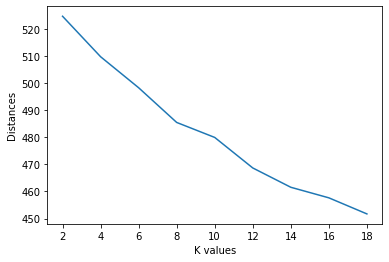

In [19]:
plt.plot(k_values, distances)
plt.xlabel('K values')
plt.ylabel('Distances')

In [21]:
with mlflow.start_run(run_name='Base Model'):
    k = 5
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    mlflow.log_param('Model', f'K-Means with cluster{k}')
    mlflow.log_param('Vectorizer', 'Tfidf')
    mlflow.sklearn.log_model(km, 'K-Means')

## Final Model

In [ ]:
##### To download <python -m spacy download fr_core_news_sm>

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)

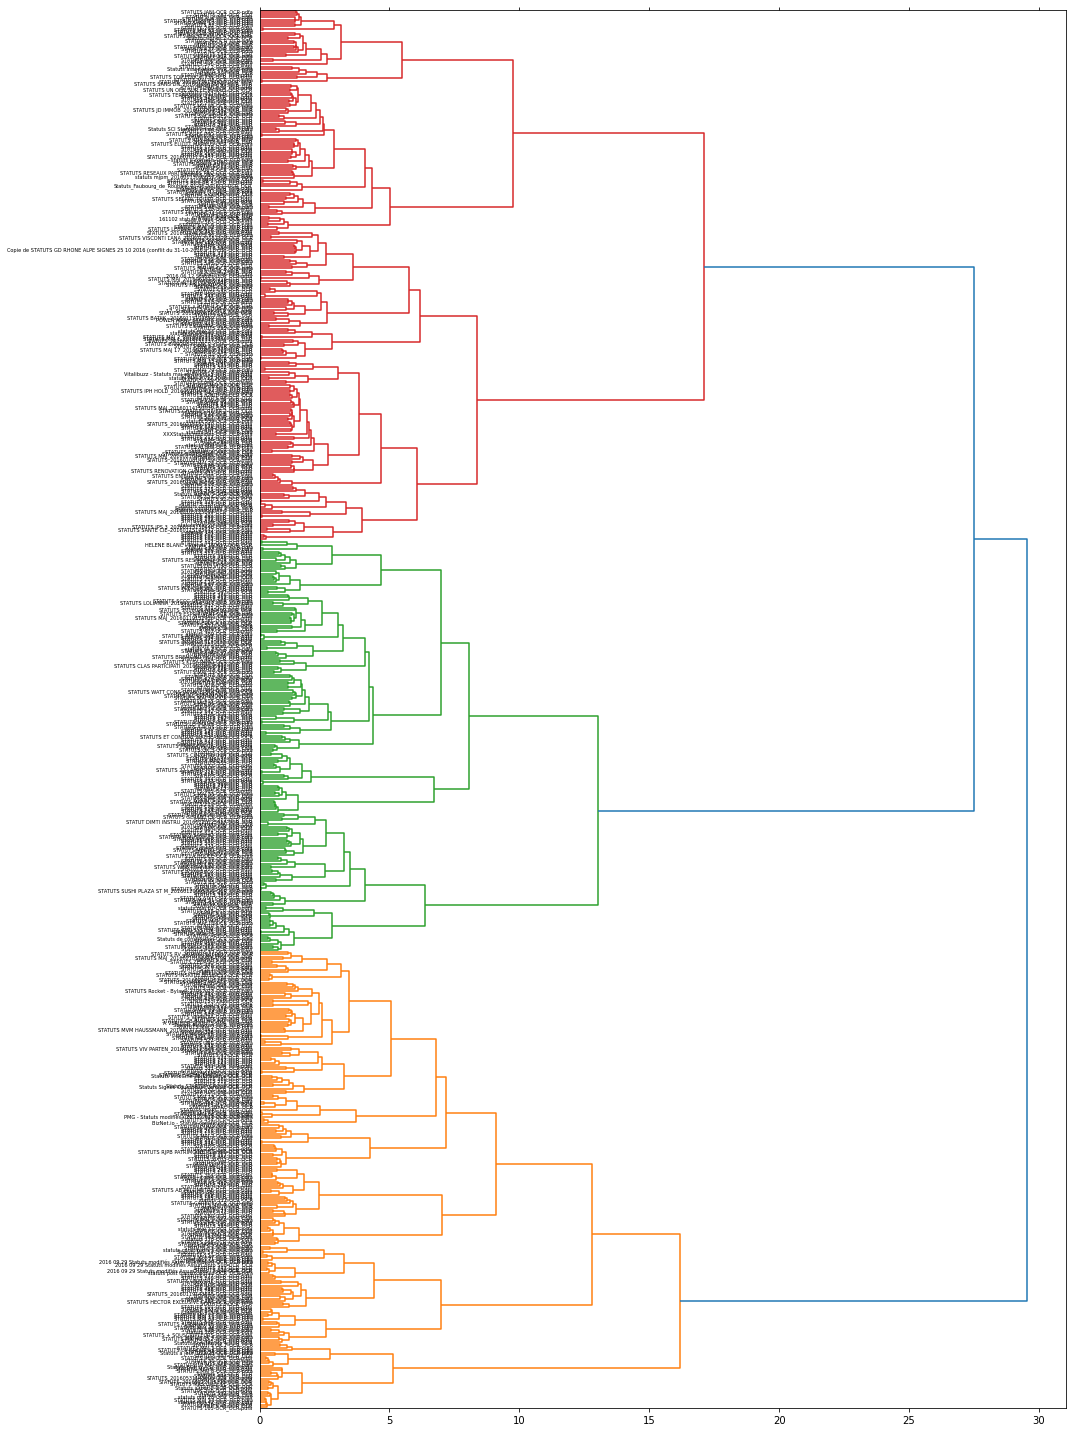

In [26]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=df['filename'].to_list());

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

# Evaluation

In [97]:
labels = km.labels_

In [98]:
f_names = df['filename'].unique()

result_df = pd.DataFrame(list(zip(f_names,clauses, labels)),columns=['f_names','clauses','cluster' ])
result_df.head()

,f_names,clauses,cluster
0,161102 statuts à jour -OCR_OCR-pdfa,pdm networks societe a responsabilite limitee ...,3
1,17. Statuts post RK-OCR_OCR-pdfa,iniflux société par actions simplifiée au capi...,1
2,2016 06 12 Statuts-OCR_OCR-pdfa,ici société par actions simplifiée au capital ...,1
3,2016 09 29 Statuts modifiés AssurCopro - copie...,assurcopro société par actions simplifiée au c...,4
4,2016 09 29 Statuts modifiés AssurCopro Sud-OCR...,assurcopro sud société par actions simplifiée ...,4


In [99]:
result_df['cluster'].value_counts()

3    266
1    253
4     78
0     31
2     18
Name: cluster, dtype: int64

In [93]:
def remove_stopwords_from_string(text):
    """
    Removes stopwords from a string
    
    """
    text = ' '.join([word for word in text.split() if word not in stop_word_list])
    
    return text

Sorting getting the closest word near the centroid so that we can know about the category

In [103]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [114]:
for i in range(k):
    print('Cluster %d:' % i),
    for j in order_centroids[i, :20]:
        print(feature_names[j], ',' , end = ' ')
    
    print('\n')
    for f in result_df[result_df['cluster'] == i]['f_names'][:10]:
        print(f, ',', end=' ')
        
    print('\n\n')

Cluster 0:
société , associés , actions , associé , président , capital , décision , social , comptes , droit , cas , décisions , agrément , statuts , article , conditions , qu , loi , exercice , titre , 

Copie de STATUTS GD RHONE ALPE SIGNES 25 10 2016 (conflit du 31-10-2016 à 11h39)-OCR_OCR , STATUTS - copie-OCR_OCR-pdfa , statuts 117-OCR_OCR , STATUTS 13-OCR_OCR-pdfa , STATUTS 137-OCR_OCR-pdfa , STATUTS 150-OCR_OCR , STATUTS 168-OCR_OCR-pdfa , STATUTS 180-OCR_OCR-pdfa , STATUTS 195-OCR_OCR-pdfa , STATUTS 211-OCR_OCR-pdfa , 


Cluster 1:
société , associés , actions , président , capital , associé , cas , social , décision , comptes , droit , qu , décisions , statuts , actionnaires , conditions , article , exercice , assemblée , titres , 

17. Statuts post RK-OCR_OCR-pdfa , 2016 06 12 Statuts-OCR_OCR-pdfa , A VERIFIER STATUTS-OCR_OCR-pdfa , BizNet.io - Statuts constitutifs-OCR_OCR , LOGOS STATUTS-OCR_OCR-pdfa , PMG - Statuts modifiés - 22.12.2016-OCR_OCR-pdfa , POWER MAN - STATUTS-O

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
components = pca.fit_transform(X.todense())

xs, ys = components[:, 0], components[:, 1]

In [142]:
dist[0]

array([-6.66133815e-16,  9.26131585e-01,  9.07527301e-01,  8.90248211e-01,
        8.93172302e-01,  8.92825454e-01,  8.97537207e-01,  8.90281337e-01,
        9.28345767e-01,  8.37939387e-01,  9.26043838e-01,  8.82366919e-01,
        9.34140585e-01,  9.02436814e-01,  8.47359151e-01,  9.50899129e-01,
        9.35714785e-01,  8.86993273e-01,  9.21359821e-01,  8.64673294e-01,
        7.96981341e-01,  8.84700392e-01,  8.85569835e-01,  9.03605979e-01,
        7.67653463e-01,  8.86754296e-01,  9.23517989e-01,  9.09010849e-01,
        9.04367277e-01,  9.08880291e-01,  9.08982164e-01,  8.17879993e-01,
        8.90909504e-01,  8.65112943e-01,  8.87790188e-01,  8.86845762e-01,
        7.59082076e-01,  9.40628786e-01,  8.49708810e-01,  8.29054029e-01,
        8.95903593e-01,  8.35126204e-01,  8.35111955e-01,  9.10587243e-01,
        8.54199220e-01,  9.70282795e-01,  8.41314577e-01,  8.36675614e-01,
        8.91805950e-01,  8.89036665e-01,  8.80978845e-01,  9.03268130e-01,
        8.87991752e-01,  

In [52]:
print('Prediction')
X = vectorizer.transform(['associés président associé comptes décisions unique société assemblée décision cas'])
predicted = km.predict(X)
print(predicted)

Prediction
[0]


In [68]:
dump(km, '../deployment/k_means_clustering.pkl')

['../deployment/k_means_clustering.pkl']

In [75]:
X = vectorizer.transform(['subaandh'])
predicted = km.predict(X)

In [76]:
predicted

array([3])